In [1]:
from datetime import date
from glob import glob
import io
import json
import os
from pathlib import Path
import pickle
from PIL import Image
import sys
import time

from matplotlib import animation
from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mplcursors
import numpy as np
import pandas as pd
from pptx import Presentation
from pptx.util import Inches
from scipy import fftpack, interpolate, ndimage, signal, stats

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind

In [5]:
%matplotlib widget

## Functions

In [6]:
def save_fig_to_pptx(fig, prs, slide=None, position=None):
    slide_W = 12; slide_H = 6
    set_dpi = 100

    # Save the Matplotlib figure to an in-memory buffer with tight bounding box
    image_buffer = io.BytesIO()
    fig.savefig(image_buffer, format='png', facecolor='white', dpi=set_dpi, bbox_inches='tight')#,pad_inches=0.1)
    image_buffer.seek(0)
    
    # Get figure size
    image = Image.open(image_buffer)
    width, height = image.size
    fig_W_inches = width / set_dpi
    fig_H_inches = height / set_dpi
    
    margin_pad = 0.1
    # Create new slide if none given
    # slide_layouts[5] is a title-only slide
    # slide_layouts[6] is a blank slide
    if slide is None:
        slide = prs.slides.add_slide(prs.slide_layouts[6])

    # Resize the figure if it's larger than the slide dimensions
    if fig_W_inches > slide_W or fig_H_inches > slide_H:
        # Calculate the scaling factor to fit within the slide
        scale_x = slide_W / fig_W_inches
        scale_y = slide_H / fig_H_inches

        # Use the smaller scaling factor to maintain the aspect ratio
        scale = min(scale_x, scale_y)

        # Set the new figure size
        fig.set_size_inches(fig_W_inches * scale, fig_H_inches * scale)
        fig_W_inches = fig.get_figwidth()
        fig_H_inches = fig.get_figheight()

    # Calculate the position and size to center the figure on the slide
    if position is None:
        left = (slide_W - fig_W_inches) / 2  # Center horizontally
        top = (slide_H - fig_H_inches) / 2  # Center vertically
    else:
        left = position[0]; top = position[1]

    # Convert to float point length (?)
    left = left * Inches(1)
    top = top * Inches(1)
    width = fig_W_inches * Inches(1)
    height = fig_H_inches * Inches(1)

    # Add the figure from the in-memory buffer to the slide
    pic = slide.shapes.add_picture(image_buffer, left, top, width, height)
    
    # Close the in-memory buffer
    image_buffer.close()
    image.close()

# Load experiment

In [7]:
data_dir = Path(r"P:\\")
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\CL-CM stim\subject_metadata.csv")
all_subexp = pd.read_csv(subject_csv)
all_subexp.head()

,mouse,sex,DOB,strain,exp_folder,histology,EEG,stim_tip_distance,tiparea,dist_CL,color
0,mouse771424,F,NaN,C57BL/6J,THstim_d1_2024-11-14_11-28-16,True,False,300,TH,0.925338,tomato
1,mouse771424,F,NaN,C57BL/6J,THstim_d2_2024-11-15_10-51-49,True,False,300,CP,1.494992,firebrick
2,mouse771425,F,NaN,C57BL/6J,THstim_d1_2024-11-21_10-59-24,True,False,300,PAL,1.286954,limegreen
3,mouse771425,F,NaN,C57BL/6J,THstim_d2_2024-11-22_10-49-58,True,False,300,int,1.435270,forestgreen
4,mouse771426,M,NaN,C57BL/6J,THstim_d1_2024-12-19_12-19-39,True,False,100,AV,0.686477,violet


In [8]:
choose_sub = 7
exprow = all_subexp.iloc[choose_sub]
data_path = os.path.join(data_dir, exprow.mouse, exprow.exp_folder, 'experiment1', 'recording1')
exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation


In [9]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\analysis\THstim_project', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

THstim_d2


Get coords for stim electrode

## Load other data

### Load stim log and simple log

In [10]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
else:
    print('No stim log found.')

In [11]:
simple_log_file = exp.stimulus_log_file[:exp.stimulus_log_file.find('estim_log')] + 'simple_' + exp.stimulus_log_file[exp.stimulus_log_file.find('estim_log'):]
if os.path.exists(simple_log_file):
    simple_log = pd.read_csv(simple_log_file)
elif os.path.exists(os.path.join(exp.data_folder, r'simple_estim_log.csv')):
    simple_log = pd.read_csv(os.path.join(exp.data_folder, r'simple_estim_log.csv'))
else:
    print('No simple log found')

In [12]:
simple_log.head()

,stim_type,parameter,duration,onset,offset,sweep
0,freq50Hz,10,20,1377.05180,1397.05193,0
1,freq50Hz,50,20,1488.10577,1508.10590,0
2,freq50Hz,50,40,1608.41940,1648.41965,0
3,freq50Hz,50,40,1748.36228,1788.36253,0
4,freq50Hz,100,40,1878.41344,1918.41369,0


### Load isoflurane signal

In [13]:
iso_level, isots = exp.load_analog_iso()
iso_induction, iso_maintenance = exp.load_iso_times()

### Load pupil diameter, if it exists

In [14]:
if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
    pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
    pupildf = pd.read_csv(pupil_file)
  
    pupilts = pupildf.sync_time.values
    pupilR = pupildf.Largest_Radius.values
    ## smooth pupil diameter, then normalize ##
    sm_pupil = np.zeros_like(pupilR)
    k = 5 # filter window is actually k*2+1
    for i in range(k, len(pupilR)-k-1):
        sm_pupil[i] = np.mean(pupilR[i-k:i+k]) # each point is the average of k surrounding points
    sm_pupil[:k] = pupilR[:k]
    sm_pupil[-k-1:] = pupilR[-k-1:]
    pupil = sm_pupil / np.mean(pupildf.Eye_Diameter.values)
    print('{:d}% of frames do not have good pupil measurements'.format(int((np.sum(np.isnan(pupilR)) / len(pupilR)) * 100)))
else:
    print('No local Pupileye*.csv file. Check server.')

0% of frames do not have good pupil measurements


In [15]:
awake_pupil_mean = np.nanmean(sm_pupil[pupilts < iso_induction[0]])
awake_pupil_std = np.nanstd(sm_pupil[pupilts < iso_induction[0]])

### Load running

In [16]:
running_file = os.path.join(exp.data_folder, 'running_signal.npy')
running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')

if os.path.exists(running_file) and os.path.exists(running_ts_file):
    speed = np.load(running_file)
    speedts = np.load(running_ts_file)

Create 10 s windows in speed time and divide into rest/run

In [17]:
deltat = 10. # window size, s
awakebins = np.arange(isots[0], iso_induction[0], deltat)
firstind = np.nonzero(stim_log.onset.values > iso_maintenance[0])[0][0]
isobins = np.arange(iso_maintenance[0], stim_log.onset.values[firstind], deltat)

Get mean speed within the time bins

In [18]:
tempsp = []
for x in awakebins:
    tempsp.append(np.mean(speed[np.nonzero((speedts >= x) & (speedts < x + deltat))[0]]))
awakespeeds = np.array(tempsp)[:-1]

tempsp = []
for x in isobins:
    tempsp.append(np.mean(speed[np.nonzero((speedts >= x) & (speedts < x + deltat))[0]]))
isospeeds = np.array(tempsp)[:-1]

### Load unit data

In [19]:
fn_units_info = os.path.join(exp.data_folder, 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(exp.data_folder, 'units_allspikes.pkl'), 'rb') as unit_file:
        all_unit_all_spikes = pickle.load(unit_file)
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))

unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region
0,D1,probeD,12,3520,0.164824,MRN,341,159,197,5.457882,0.83,0.033551,0.122209,24564,MB
1,D3,probeD,18,3460,0.494472,MRN,342,156,195,3.335076,0.80,0.037437,0.000143,15010,MB
2,D5,probeD,50,3140,0.384590,MRN,344,145,187,4.518239,0.94,0.771015,0.500000,20335,MB
3,D6,probeD,60,3040,0.343384,MRN,344,141,185,4.096966,0.98,4.572036,0.500000,18439,MB
4,D8,probeD,54,3100,0.315913,MRN,344,143,186,0.041550,0.33,0.000000,0.332388,187,MB


# Get population firing rates for events

In [68]:
choose_event = 10
eventrow = simple_log.iloc[choose_event]
print(eventrow)

stim_type      freq50Hz
parameter           100
duration             40
onset        3227.98436
offset       3267.98458
sweep                 0
Name: 10, dtype: object


In [20]:
print(np.unique(unit_info['parent_region'].values))

['ACA' 'HIP' 'HPF' 'MB' 'MO' 'RHP' 'SS' 'STR' 'TH' 'VIS']


Plot 2 events

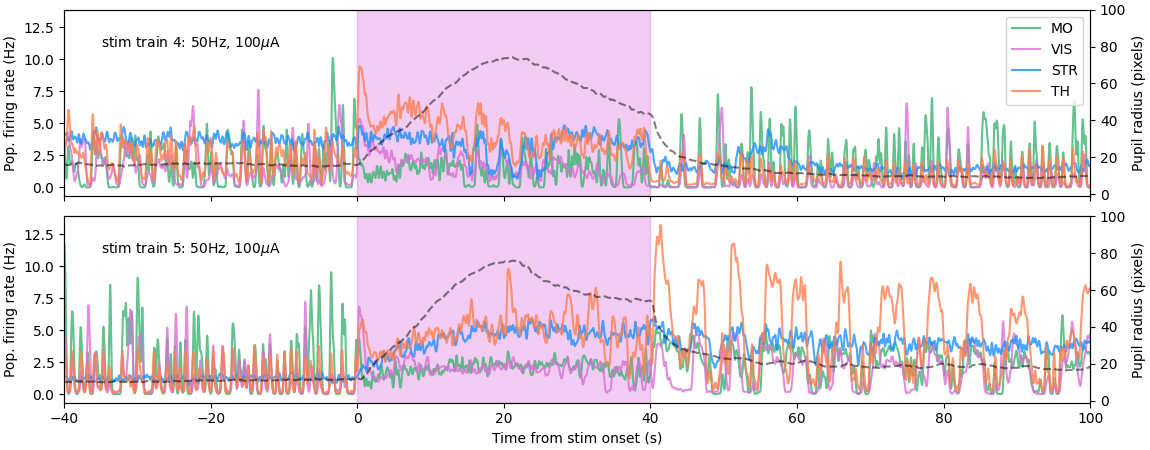

In [20]:
plot_events = [4, 5]

plot_regions = {
    'MO': 'mediumseagreen',
    'VIS': 'orchid',
    'STR': 'dodgerblue',
    'TH': 'coral',
}

## Parameters ##
time_bin = 0.005 # size of time bins (s)
timewin = [-40., 60.]

fig, axs = plt.subplots(2, 1, figsize=(11.5,4.5), constrained_layout=True, sharex=True, sharey=True)
for ax, pevi in zip(axs, plot_events):
    eventrow = simple_log.iloc[pevi]
    clockwin = [eventrow.onset + timewin[0], eventrow.offset + timewin[1]]
    event_bins = np.arange(clockwin[0], clockwin[1], time_bin)
    timex = event_bins[:-1] - eventrow.onset
    ax.axvspan(0, eventrow.duration, color='m', alpha=0.2)
    for regi, rcol in plot_regions.items():
        regidf = unit_info[unit_info['parent_region'] == regi]
        counts = []
        for uind, unitrow in regidf.iterrows():
            uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
            spcounts, edges = np.histogram(uspikes, event_bins)
            counts.append(spcounts)
        popfr = np.mean(np.stack(counts), axis=0) / (time_bin)# * len(regi_unitdf))
        popSDF = ndimage.gaussian_filter(popfr, sigma=20, output=float)
        ax.plot(timex, popSDF, color=rcol, alpha=0.8, label=regi)

    ax.set_xlim([timewin[0], eventrow.duration + timewin[1]])
    ax.set_ylabel('Pop. firing rate (Hz)')
    etag = 'stim train {:d}: {}, {:d}$\mu$A'.format(pevi, eventrow.stim_type[4:], eventrow.parameter)
    ax.annotate(etag, xy=(-35, 12), xycoords='data', va='top')
    
    pax = ax.twinx()
    pupinds = np.nonzero((pupilts >= clockwin[0]) & (pupilts <= clockwin[1]))
    puptimex = pupilts[pupinds] - eventrow.onset
    # ax.axhspan(awake_pupil_mean - awake_pupil_std, awake_pupil_mean + awake_pupil_std, color='b', alpha=0.1)
    # ax.axhline(awake_pupil_mean, color='b', linewidth=1.0, linestyle='dashed', alpha=0.3)
    pax.plot(puptimex, sm_pupil[pupinds], color='k', linestyle='dashed', alpha=0.5)
    pax.set_ylabel('Pupil radius (pixels)')
    pax.set_ylim([-1, 100])
axs[1].set_xlabel('Time from stim onset (s)')
axs[0].legend(loc='upper right')

### SAVE ###
fig_name = '{}_evokedpopFR_events45.png'.format(exp_tag)
fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

Loop through units

In [30]:
rrdict = {'rest': awakespeeds == 0, 'run': awakespeeds > 1}
rrFR = {'rest': [], 'run': []}
rrBR = {'rest': [], 'run': []}
isoFR = []
isoBR = []
all_units_eventfr = np.zeros((len(unit_info), len(simple_log)), dtype=float)
for unitind, unitrow in unit_info.iterrows():
    uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
    ubursts = all_unit_all_spikes[unitrow.unit_id]['bursts']
    ## Awake ##
    Aspikec, edges = np.histogram(uspikes, awakebins)
    Aburstc, edges = np.histogram(ubursts, awakebins)
    for sti, rbins in rrdict.items():
        if np.sum(rbins) == 0:
            rrFR[sti].append(np.nan)
            rrBR[sti].append(np.nan)
        else:
            rrFR[sti].append(np.mean(Aspikec[rbins] / deltat))
            rrBR[sti].append(np.mean(Aburstc[rbins] / deltat))
    ## Isoflurane ##
    Ispikec, edges = np.histogram(uspikes, isobins)
    isoFR.append(np.mean(Ispikec[isospeeds == 0] / deltat))
    Iburstc, edges = np.histogram(ubursts, isobins)
    isoBR.append(np.mean(Iburstc[isospeeds == 0] / deltat))

    ## Get evoked firing rates ##
    for ei, eventrow in simple_log.iterrows():
        all_units_eventfr[unitind, ei] = (
            len(np.nonzero((uspikes >= eventrow.onset) & (uspikes < eventrow.offset))[0]) / (eventrow.offset - eventrow.onset))

unit_info['rest_FR'] = rrFR['rest']
unit_info['run_FR'] = rrFR['run']
unit_info['iso_FR'] = isoFR
unit_info['rest_BR'] = rrBR['rest']
unit_info['run_BR'] = rrBR['run']
unit_info['iso_BR'] = isoBR

### Plot firing rates

In [31]:
## Subselect units to remove low spiking ones ##
select_units = unit_info[unit_info['spike_count'] > 500]
print(len(select_units))
parent_regions = np.unique(select_units['parent_region'].values)

1331


In [37]:
colordict = {'rest': ['blue'], 'run': ['green'], 'iso': ['red'], 'evoked': ['magenta']}
compspont = {}
compevent = {}
for sti, stinfo in colordict.items():
    if sti == 'rest':
        if np.sum(rrdict[sti]) > 0:
            compspont[sti] = stinfo
            compevent[sti] = stinfo
    if sti == 'run':
        if np.sum(rrdict[sti]) > 0:
            compspont[sti] = stinfo
            if 'rest' not in compevent.keys():
                compevent[sti] = stinfo
    elif sti == 'iso':
        compspont[sti] = stinfo
        compevent[sti] = stinfo
    elif sti == 'evoked':
        compevent[sti] = stinfo

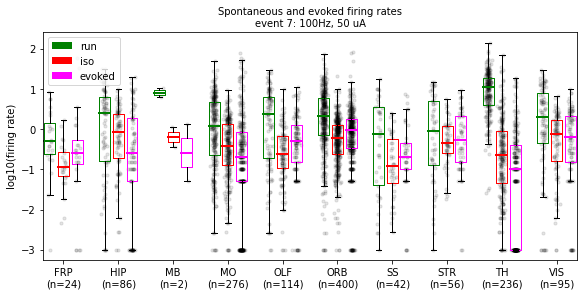

In [38]:
choose_event = 7
eventrow = simple_log.iloc[choose_event]
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
xlocs = np.arange(len(parent_regions) * (len(compevent) + 1)).reshape((len(parent_regions), -1))

rlabels = []
for ii, pregi in enumerate(parent_regions):
    regidf = select_units[select_units['parent_region'] == pregi]
    rlabels.append('{}\n(n={:d})'.format(pregi, len(regidf)))
    for jj, (statei, sinfo) in enumerate(compevent.items()):
        if statei == 'evoked':
            yvals = np.log10(all_units_eventfr[regidf.index, choose_event] + 1E-3)
        else:
            yvals = np.log10(regidf[statei + '_FR'].values + 1E-3)
        xs = np.random.normal(xlocs[ii, jj], 0.1, len(yvals))
        ax.boxplot(
            yvals, positions=[xlocs[ii, jj]], widths=[0.8], showfliers=False,
            medianprops={'color': sinfo[0], 'linewidth': 2}, boxprops={'color': sinfo[0]}
        )
        ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
ax.set_xticks(np.mean(xlocs[:,:-1], axis=1))
ax.set_xticklabels(rlabels)
ax.set_ylabel('log10(firing rate)')
ax.set_title('Spontaneous and evoked firing rates\nevent {:d}: {}, {:d} uA'.format(choose_event, eventrow.stim_type[4:], eventrow.parameter))

leggies = []
for statei, sinfo in compevent.items():
    leggies.append(mpatches.Rectangle((0, 0), 1, 1, fc=sinfo[0], label=statei))
ax.legend(handles=leggies)

Plot one region, all events

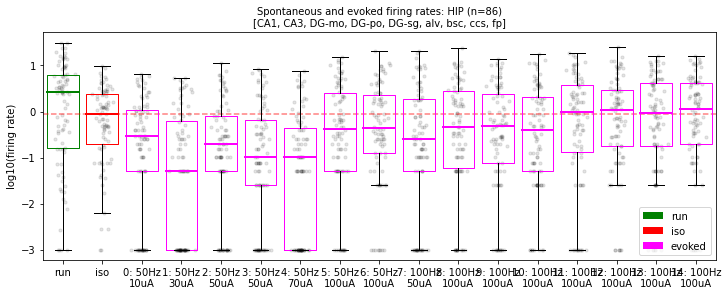

In [39]:
choose_regi = 'HIP'
regidf = select_units[select_units['parent_region'] == choose_regi]

fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)

indi = 0
ticks = []
labels = []
for jj, (statei, sinfo) in enumerate(compevent.items()):
    if statei == 'evoked':
        for ei in range(all_units_eventfr.shape[1]):
            yvals = np.log10(all_units_eventfr[regidf.index, ei] + 1E-3)
            xs = np.random.normal(indi, 0.1, len(yvals))
            ax.boxplot(
                yvals, positions=[indi], widths=[0.8], showfliers=False, medianprops={'color': sinfo[0], 'linewidth': 2}, boxprops={'color': sinfo[0]}
                )
            ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
            ticks.append(indi)
            labels.append('{:d}: {}\n{:d}uA'.format(ei, simple_log.iloc[ei].stim_type[4:], simple_log.iloc[ei].parameter))
            indi += 1
    else:
        yvals = np.log10(regidf[statei + '_FR'].values + 1E-3)
        xs = np.random.normal(indi, 0.1, len(yvals))
        ax.boxplot(
            yvals, positions=[indi], widths=[0.8], showfliers=False, medianprops={'color': sinfo[0], 'linewidth': 2}, boxprops={'color': sinfo[0]}
            )
        ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
        ticks.append(indi)
        labels.append(statei)
        if statei == 'iso':
            ax.axhline(np.median(yvals), color='r', linestyle='dashed', alpha=0.5)
        indi += 1

ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_ylabel('log10(firing rate)')
ax.set_title('Spontaneous and evoked firing rates: {} (n={:d})\n[{}]'.format(choose_regi, len(regidf), ', '.join(np.unique(regidf.region.values))))

leggies = []
for statei, sinfo in compevent.items():
    leggies.append(mpatches.Rectangle((0, 0), 1, 1, fc=sinfo[0], label=statei))
ax.legend(handles=leggies)

Plot the spontaneous firing rates

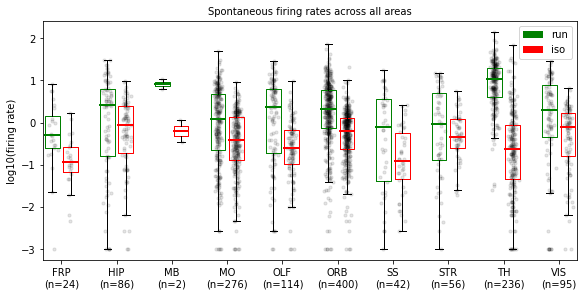

In [40]:
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)

xlocs = np.arange(len(parent_regions) * (len(compspont) + 1)).reshape((len(parent_regions), -1))

rlabels = []
for ii, pregi in enumerate(parent_regions):
    regidf = select_units[select_units['parent_region'] == pregi]
    rlabels.append('{}\n(n={:d})'.format(pregi, len(regidf)))
    for jj, (statei, sinfo) in enumerate(compspont.items()):
        yvals = np.log10(regidf[statei + '_FR'].values + 1E-3)
        xs = np.random.normal(xlocs[ii, jj], 0.1, len(yvals))
        ax.boxplot(
            yvals, positions=[xlocs[ii, jj]], widths=[0.8], showfliers=False,
            medianprops={'color': sinfo[0], 'linewidth': 2}, boxprops={'color': sinfo[0]}
        )
        ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
ax.set_xticks(np.mean(xlocs[:,:-1], axis=1))
ax.set_xticklabels(rlabels)
ax.set_ylabel('log10(firing rate)')
ax.set_title('Spontaneous firing rates across all areas')

leggies = []
for statei, sinfo in compspont.items():
    leggies.append(mpatches.Rectangle((0, 0), 1, 1, fc=sinfo[0], label=statei))
ax.legend(handles=leggies)

## Plots for one subject, add to test ppt

Now loop through all parent regions and add plots to ppt

Now save the ppt

## Test evoked firing rate on some units

In [18]:
simple_log

,stim_type,parameter,duration,onset,offset,sweep
0,freq50Hz,10,20,1377.05180,1397.05193,0
1,freq50Hz,50,20,1488.10577,1508.10590,0
2,freq50Hz,50,40,1608.41940,1648.41965,0
3,freq50Hz,50,40,1748.36228,1788.36253,0
4,freq50Hz,100,40,1878.41344,1918.41369,0
5,freq50Hz,100,40,2118.02391,2158.02416,0
6,freq100Hz,50,40,2389.13647,2429.13671,0
7,freq100Hz,100,40,2518.52211,2558.52236,0
8,freq100Hz,100,40,2728.72235,2768.72259,0
9,freq50Hz,100,40,2984.99033,3024.99057,0


#### Testing single unit

In [33]:
unitind = 625
unitrow = unit_info.iloc[unitind]
print('Unit {}, {}: spike duration={:.2f}, spike count={:d}'.format(unitrow.unit_id, unitrow.region, unitrow.spike_duration, unitrow.spike_count))

Unit F70, MOs6a: spike duration=0.59, spike count=13929


In [34]:
uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
print(len(uspikes))
ubursts = all_unit_all_spikes[unitrow.unit_id]['bursts']
print(len(ubursts))

13929
239


Just get event spike count. It is easier than doing bins and gives equal values.

In [45]:
len(np.nonzero((uspikes >= eventrow.onset) & (uspikes < eventrow.offset))[0]) / (eventrow.offset - eventrow.onset)

6.799957500265615

Do it for all stim trains

In [58]:
BL_FR = np.zeros((len(simple_log)), dtype=float)
event_FR = np.zeros((len(simple_log)), dtype=float)
for ei, eventrow in simple_log.iterrows():
    event_FR[ei] = len(np.nonzero((uspikes >= eventrow.onset) & (uspikes < eventrow.offset))[0]) / (eventrow.offset - eventrow.onset)
    BL_FR[ei] = len(np.nonzero((uspikes > eventrow.onset - eventrow.duration) & (uspikes < eventrow.onset))[0]) / eventrow.duration

In [57]:
event_FR

array([0.74999513, 1.09999285, 1.97498766, 0.87499453, 2.92498172,
       9.49994063, 0.82499505, 6.7999575 , 4.72497165, 2.4499853 ,
       0.72499601])

In [59]:
BL_FR

array([0.35 , 0.9  , 0.45 , 0.575, 0.9  , 1.075, 0.55 , 0.9  , 1.   ,
       0.7  , 0.6  ])

Plot firing rate SDF across whole recording

In [54]:
time_bin = 0.005 # size of time bins (s)
totalFR_bins = np.arange(uspikes[0], uspikes[-1], time_bin)
spikets = totalFR_bins[:-1] + time_bin/2
print(len(spikets))
spcounts, edges = np.histogram(uspikes, totalFR_bins)
burstcounts, edges = np.histogram(ubursts, totalFR_bins)
SDF = ndimage.gaussian_filter(spcounts, sigma=20, output=float) / time_bin
BDF = ndimage.gaussian_filter(burstcounts, sigma=20, output=float) / time_bin

899948


Text(0.5, 1.0, '771427 - THstim_d2: stim elec in CL')

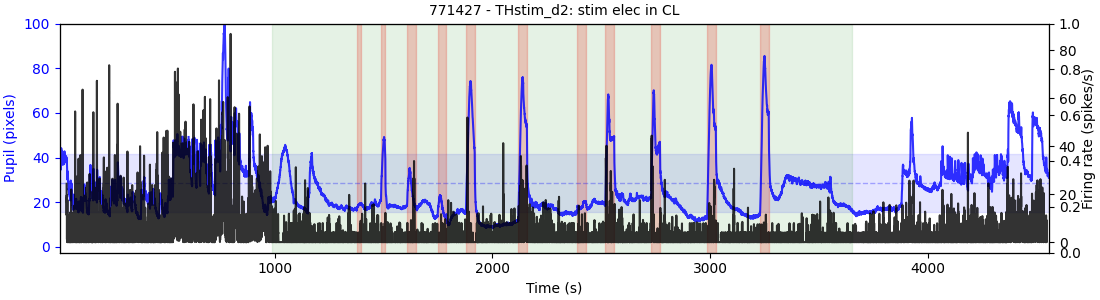

In [55]:
fig, ax = plt.subplots(figsize=(11,3), constrained_layout=True)
## Pupil ##
ax.axhspan(awake_pupil_mean - awake_pupil_std, awake_pupil_mean + awake_pupil_std, color='b', alpha=0.1)
ax.axhline(awake_pupil_mean, color='b', linewidth=1.0, linestyle='dashed', alpha=0.3)
pupat = mpatches.Rectangle((0, 0), 1, 1, fc='b', alpha=0.1, label='awake pupil')
pup, = ax.plot(pupilts, sm_pupil, color='b', alpha=0.8, label='pupil')
ax.set_xlim([pupilts[0], pupilts[-1]])
ax.set_ylim([-2.5, 100])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil (pixels)', color='b')
ax.tick_params(axis='y', colors='b')
## Add stim events ##
for ii, traini in simple_log.iterrows():
    ax.axvspan(traini.onset, traini.offset, color='r', alpha=0.2)
spat = mpatches.Rectangle((0, 0), 1, 1, fc='r', alpha=0.2, label='stim train')
## Running ##
FRax = ax.twinx()
FR, = FRax.plot(spikets, SDF, color='k', alpha=0.8, label='firing rate')
FRax.set_ylabel('Firing rate (spikes/s)', color='k')
FRax.tick_params(axis='y', colors='k')
# runax.set_ylim([-2.5, 50])
## Iso level ##
ax.axvspan(iso_maintenance[0], iso_maintenance[1], color='g', alpha=0.1)
isp = mpatches.Rectangle((0, 0), 1, 1, fc='g', alpha=0.1, label='iso')
isoax = ax.twinx()

## Set title and legend ##
ax.set_title('{} - {}: stim elec in {}'.format(exp.mouse, exp_tag, stim_elec_data['tip']['area']))
# ax.legend(handles = [pup, pupat, run, isp, spat], loc='upper right')

#### Get population firing rate

#### Plot an event raster

In [28]:
choose_event = 4
eventrow = simple_log.iloc[choose_event]
print(eventrow)
event_stims = stim_log[stim_log['event_ID'] == choose_event]
event_stims.head()

stim_type      freq50Hz
parameter           100
duration             40
onset        1878.41344
offset       1918.41369
sweep                 0
Name: 4, dtype: object


,event_type,event_ID,stim_type,parameter,onset,offset,duration,sweep
6000,freq50Hz,4,biphasic,100,1878.41344,1878.41384,0.0004,0
6001,freq50Hz,4,biphasic,100,1878.43344,1878.43384,0.0004,0
6002,freq50Hz,4,biphasic,100,1878.45344,1878.45384,0.0004,0
6003,freq50Hz,4,biphasic,100,1878.47344,1878.47384,0.0004,0
6004,freq50Hz,4,biphasic,100,1878.49344,1878.49384,0.0004,0


[Text(0, 0, ''),
 Text(0, 101, ''),
 Text(0, 160, ''),
 Text(0, 225, ''),
 Text(0, 327, ''),
 Text(0, 356, ''),
 Text(0, 433, '')]

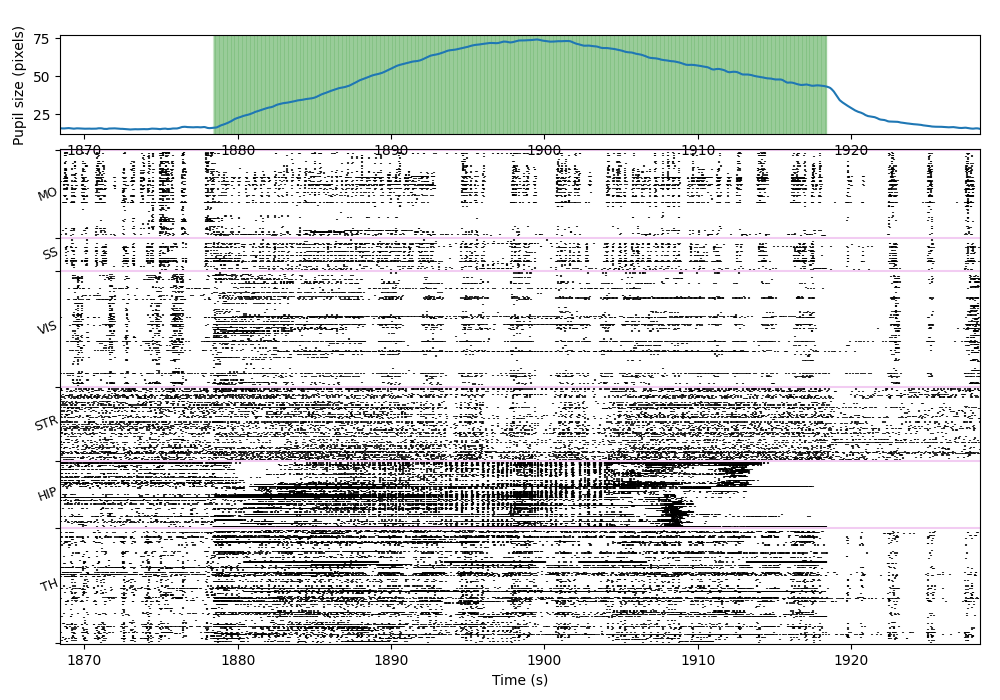

In [30]:
plot_regions = ['TH', 'HIP', 'STR', 'VIS', 'SS', 'MO']
umax = 100
pdelta = 10. # plot before and after, s
pwindow = [eventrow.onset - pdelta, eventrow.offset + pdelta]

fig = plt.figure(figsize=(10, 7)) # (10,10)
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.06, right=0.98, top=0.95, bottom=0.08, hspace=0.05, height_ratios=[1,5])
aax = fig.add_subplot(gs[0])
rasterax = fig.add_subplot(gs[1], sharex=aax)

## Plot pupil ##
pupilinds = np.nonzero((pupilts > pwindow[0]) & (pupilts < pwindow[1]))[0]
aax.axvspan(eventrow.onset, eventrow.offset, color='g', alpha=0.05)
# aax.axhspan(awake_pupil_mean - awake_pupil_std, awake_pupil_mean + awake_pupil_std, color='b', alpha=0.05)
# aax.axhline(awake_pupil_mean, color='b', linestyle='dashed', alpha=0.2)
for si, stimi in event_stims.iterrows():
    aax.axvline(stimi.onset, color='g', linewidth=0.5, alpha=0.2)
aax.plot(pupilts[pupilinds], sm_pupil[pupilinds])
aax.set_xlim(pwindow)
# aax.set_xlabel('Time (s)')
aax.set_ylabel('Pupil size (pixels)')

## Plot raster ##
last_ind = 0
regb = [last_ind]
for ii, pregi in enumerate(plot_regions):
    regdf = unit_info[unit_info['parent_region'] == pregi].sort_values(by='depth', ascending=False).reset_index(drop=True)
    if len(regdf) > umax:
        punitinds = np.random.choice(range(len(regdf)), size=umax, replace=False)
    else:
        punitinds = range(len(regdf))
    for indi in punitinds:
        urow = regdf.iloc[indi]
        uspiketimes = all_unit_all_spikes[urow.unit_id]['spikes']
        SWDspikes = uspiketimes[
            np.nonzero((uspiketimes > pwindow[0]) & (uspiketimes < pwindow[1]))[0]
        ]
        rasterax.eventplot(SWDspikes, lineoffsets=last_ind, linelengths=1.0, color='black', alpha=0.8)
        last_ind += 1
    rasterax.annotate(
        '{}'.format(pregi), xy=(pwindow[0], last_ind - len(punitinds)/2), xycoords='data',
        annotation_clip=False, rotation=20, ha='right', va='center', fontsize=9
    )
    last_ind += 2
    regb.append(last_ind - 1)
    rasterax.axhline(last_ind - 1, color='m', alpha=0.2)

rasterax.set_ylim(-1, last_ind)
rasterax.set_xlim(pwindow)
rasterax.set_xlabel('Time (s)')
rasterax.set_yticks(regb)
rasterax.set_yticklabels([])

### SAVE ###
# fig_name = 'spont_EEG_NPX_{:d}-{:d}s.png'.format(int(window[0]), int(window[1]))
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

# Loop through all subjects and plot unit firing rates

In [7]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\CL-CM stim\pictures and plots'

In [8]:
data_dir = Path(r"P:\\")
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\CL-CM stim\subject_metadata.csv")
all_subexp = pd.read_csv(subject_csv)
all_subexp.head()

,mouse,sex,DOB,strain,exp_folder,histology,EEG,stim_tip_distance
0,mouse771424,F,NaN,C57BL/6J,THstim_d1_2024-11-14_11-28-16,True,False,300
1,mouse771424,F,NaN,C57BL/6J,THstim_d2_2024-11-15_10-51-49,True,False,300
2,mouse771425,F,NaN,C57BL/6J,THstim_d1_2024-11-21_10-59-24,True,False,300
3,mouse771425,F,NaN,C57BL/6J,THstim_d2_2024-11-22_10-49-58,True,False,300
4,mouse771426,M,NaN,C57BL/6J,THstim_d1_2024-12-19_12-19-39,True,False,100


Set up the ppt

In [9]:
## Create a new PowerPoint presentation to save figures to ##
prs = Presentation()
prs.slide_width = Inches(12)
prs.slide_height = Inches(6)

## Add title slide ##
slide = prs.slides.add_slide(prs.slide_layouts[0])
slide.shapes.title.text = f'Spontaneous and stim-evoked firing rates'
slide.placeholders[1].text = 'All TH-stim pilot sessions\n{}'.format(date.today().strftime('%b %d, %Y'))

In [10]:
deltat = 10. # window size, s
unit_spike_limit = 500
colordict = {'rest': ['blue'], 'run': ['green'], 'iso': ['red'], 'evoked': ['magenta']}

for expind, exprow in all_subexp.iterrows():
    ## Load the experiment ##
    data_path = os.path.join(data_dir, exprow.mouse, exprow.exp_folder, 'experiment1', 'recording1')
    exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)
    exp_tag = exprow.exp_folder[:9]
    print('{} - {}'.format(exprow.mouse, exp_tag))
    
    stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
    if os.path.exists(stim_elec_file):
        with open(stim_elec_file) as elec_file:
            stim_elec_data = json.load(elec_file)
    else:
        print(' Stim electrode location file not found.')

    ## Load the stim log ##
    simple_log_file = (
        exp.stimulus_log_file[:exp.stimulus_log_file.find('estim_log')] + 'simple_' + exp.stimulus_log_file[exp.stimulus_log_file.find('estim_log'):])
    if os.path.exists(simple_log_file):
        simple_log = pd.read_csv(simple_log_file)
    elif os.path.exists(os.path.join(exp.data_folder, r'simple_estim_log.csv')):
        simple_log = pd.read_csv(os.path.join(exp.data_folder, r'simple_estim_log.csv'))
    else:
        print(' No simple log found')
        continue

    ## Load the running ##
    running_file = os.path.join(exp.data_folder, 'raw_running_signal.npy')
    running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')
    if os.path.exists(running_file) and os.path.exists(running_ts_file):
        speed = np.load(running_file)
        speedts = np.load(running_ts_file)
    else:
        print('No running files found.\n')
        continue

    ## Load the iso times ##
    iso_level, isots = exp.load_analog_iso()
    iso_induction, iso_maintenance = exp.load_iso_times()

    ## Load unit info ##
    fn_units_info = os.path.join(exp.data_folder, 'all_units_info.csv')
    if os.path.exists(fn_units_info):
        unit_info = pd.read_csv(fn_units_info)
        with open(os.path.join(exp.data_folder, 'units_allspikes.pkl'), 'rb') as unit_file:
            all_unit_all_spikes = pickle.load(unit_file)
    else:
        print(' {} not found. Not analyzing this subject.\n'.format(fn_units_stats))
        continue

    reglist = [x if isinstance(x, str) else 'null' for x in unit_info.region.values]
    unit_info['region'] = reglist
    
    ## Get time bins for spontaneous times ##
    awakebins = np.arange(isots[0], iso_induction[0], deltat)
    firstind = np.nonzero(simple_log.onset.values > iso_maintenance[0])[0][0]
    isobins = np.arange(iso_maintenance[0], simple_log.onset.values[firstind], deltat)
    # print(' Awake time: {:.2f} s'.format(iso_induction[0] - isots[0]))
    # print(' Iso time: {:.2f} s'.format(simple_log.onset.values[firstind] - iso_maintenance[0]))
    ## Get the speed ##
    tempsp = []
    for x in awakebins:
        tempsp.append(np.mean(speed[np.nonzero((speedts >= x) & (speedts < x + deltat))[0]]))
    awakespeeds = np.array(tempsp)[:-1]
    tempsp = []
    for x in isobins:
        tempsp.append(np.mean(speed[np.nonzero((speedts >= x) & (speedts < x + deltat))[0]]))
    isospeeds = np.array(tempsp)[:-1]
    ## Get the mean firing rate for all states and add it to the unit_info df ##
    rrdict = {'rest': awakespeeds == 0, 'run': awakespeeds > 1}
    rrFR = {'rest': [], 'run': []}
    rrBR = {'rest': [], 'run': []}
    isoFR = []
    isoBR = []
    all_units_eventfr = np.zeros((len(unit_info), len(simple_log)), dtype=float)
    for unitind, unitrow in unit_info.iterrows():
        uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
        ubursts = all_unit_all_spikes[unitrow.unit_id]['bursts']
        ## Awake ##
        Aspikec, edges = np.histogram(uspikes, awakebins)
        Aburstc, edges = np.histogram(ubursts, awakebins)
        for sti, rbins in rrdict.items():
            if np.sum(rbins) == 0:
                rrFR[sti].append(np.nan)
                rrBR[sti].append(np.nan)
            else:
                rrFR[sti].append(np.mean(Aspikec[rbins] / deltat))
                rrBR[sti].append(np.mean(Aburstc[rbins] / deltat))
        ## Isoflurane ##
        Ispikec, edges = np.histogram(uspikes, isobins)
        isoFR.append(np.mean(Ispikec[isospeeds == 0] / deltat))
        Iburstc, edges = np.histogram(ubursts, isobins)
        isoBR.append(np.mean(Iburstc[isospeeds == 0] / deltat))
        ## Get evoked firing rates ##
        for ei, eventrow in simple_log.iterrows():
            all_units_eventfr[unitind, ei] = (
                len(np.nonzero((uspikes >= eventrow.onset) & (uspikes < eventrow.offset))[0]) / (eventrow.offset - eventrow.onset))
    unit_info['rest_FR'] = rrFR['rest']
    unit_info['run_FR'] = rrFR['run']
    unit_info['iso_FR'] = isoFR
    unit_info['rest_BR'] = rrBR['rest']
    unit_info['run_BR'] = rrBR['run']
    unit_info['iso_BR'] = isoBR
    
    ## Sub-select units ##
    select_units = unit_info[unit_info['spike_count'] > unit_spike_limit]
    parent_regions = np.unique(select_units['parent_region'].values)

    compspont = {}
    compevent = {}
    for sti, stinfo in colordict.items():
        if sti == 'rest':
            if np.sum(rrdict[sti]) > 0:
                compspont[sti] = stinfo
                compevent[sti] = stinfo
        if sti == 'run':
            if np.sum(rrdict[sti]) > 0:
                compspont[sti] = stinfo
                if 'rest' not in compevent.keys():
                    compevent[sti] = stinfo
        elif sti == 'iso':
            compspont[sti] = stinfo
            compevent[sti] = stinfo
        elif sti == 'evoked':
            compevent[sti] = stinfo

    #### Now make plots and add to ppt ####
    ## Add a slide with a title and all region spontaneous firing rates ##
    subslide = prs.slides.add_slide(prs.slide_layouts[5])
    subslide.shapes.title.text = '{} {}: stim in {}'.format(exp.mouse, exp_tag, stim_elec_data['tip']['area'])
    spfig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
    xlocs = np.arange(len(parent_regions) * (len(compspont) + 1)).reshape((len(parent_regions), -1))
    rlabels = []
    for ii, pregi in enumerate(parent_regions):
        regidf = select_units[select_units['parent_region'] == pregi]
        rlabels.append('{}\n(n={:d})'.format(pregi, len(regidf)))
        for jj, (statei, sinfo) in enumerate(compspont.items()):
            yvals = np.log10(regidf[statei + '_FR'].values + 1E-3)
            xs = np.random.normal(xlocs[ii, jj], 0.1, len(yvals))
            ax.boxplot(
                yvals, positions=[xlocs[ii, jj]], widths=[0.8], showfliers=False,
                medianprops={'color': sinfo[0], 'linewidth': 2}, boxprops={'color': sinfo[0]}
            )
            ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
    ax.set_xticks(np.mean(xlocs[:,:-1], axis=1))
    ax.set_xticklabels(rlabels)
    ax.set_ylabel('log10(firing rate)')
    ax.set_title('Spontaneous firing rates across all areas')
    leggies = []
    for statei, sinfo in compspont.items():
        leggies.append(mpatches.Rectangle((0, 0), 1, 1, fc=sinfo[0], label=statei))
    ax.legend(handles=leggies)
    plt.close(spfig)
    save_fig_to_pptx(spfig, prs, slide=subslide, position=[0.95, 1.6])

    ## Now plot each region, all events, and add to ppt ##
    for regi in parent_regions:
        regidf = select_units[select_units['parent_region'] == regi]
        regfig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
        indi = 0
        ticks = []
        labels = []
        for jj, (statei, sinfo) in enumerate(compevent.items()):
            if statei == 'evoked':
                for ei in range(all_units_eventfr.shape[1]):
                    yvals = np.log10(all_units_eventfr[regidf.index, ei] + 1E-3)
                    xs = np.random.normal(indi, 0.1, len(yvals))
                    ax.boxplot(
                        yvals, positions=[indi], widths=[0.8], showfliers=False,
                        medianprops={'color': sinfo[0], 'linewidth': 2}, boxprops={'color': sinfo[0]}
                        )
                    ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
                    ticks.append(indi)
                    labels.append('{:d}: {}\n{:d}uA'.format(ei, simple_log.iloc[ei].stim_type[4:], simple_log.iloc[ei].parameter))
                    indi += 1
            else:
                yvals = np.log10(regidf[statei + '_FR'].values + 1E-3)
                xs = np.random.normal(indi, 0.1, len(yvals))
                ax.boxplot(
                    yvals, positions=[indi], widths=[0.8], showfliers=False,
                    medianprops={'color': sinfo[0], 'linewidth': 2}, boxprops={'color': sinfo[0]}
                    )
                ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
                ticks.append(indi)
                labels.append(statei)
                if statei == 'iso':
                    ax.axhline(np.median(yvals), color='r', linestyle='dashed', alpha=0.5)
                indi += 1
        ax.set_xticks(ticks)
        ax.set_xticklabels(labels)
        ax.set_ylabel('log10(firing rate)')
        ax.set_title('Spontaneous and evoked firing rates: {} (n={:d})\n[{}]'.format(regi, len(regidf), ', '.join(np.unique(regidf.region.values))))
        leggies = []
        for statei, sinfo in compevent.items():
            leggies.append(mpatches.Rectangle((0, 0), 1, 1, fc=sinfo[0], label=statei))
        ax.legend(handles=leggies)
        plt.close(regfig)
        save_fig_to_pptx(regfig, prs)
    print('')

#### Save the ppt ####
prs.save(os.path.join(plotsdir, 'All sessions spont and evoked FR {}.pptx'.format(date.today().strftime('%b%d%Y'))))

Experiment type: electrical stimulation
mouse771424 - THstim_d1

Experiment type: electrical stimulation
mouse771424 - THstim_d2

Experiment type: electrical stimulation
mouse771425 - THstim_d1

Experiment type: electrical stimulation
mouse771425 - THstim_d2

Experiment type: electrical stimulation
mouse771426 - THstim_d1

Experiment type: electrical stimulation
mouse771426 - THstim_d2

Experiment type: electrical stimulation
mouse771427 - THstim_d1

Experiment type: electrical stimulation
mouse771427 - THstim_d2

Experiment type: electrical and sensory stimulation
mouse771427 - THstim_d3

